<a href="https://colab.research.google.com/github/solayman-cs/ICH/blob/main/RSNA_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/DataSets/small_rsna_v1

/content/drive/My Drive/DataSets/small_rsna_v1


In [3]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.3 MB/s 


In [4]:
import os
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imgaug import augmenters as iaa

import tensorflow as tf

In [ ]:
os.listdir()

['stage_2_sample_submission.csv',
 'stage_2_train.csv',
 'stage_2_test',
 'stage_2_train']

In [ ]:
train_df = pd.read_csv("stage_2_train.csv")
train_df.head(10)

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
5,ID_12cadc6af_any,0
6,ID_38fd7baa0_epidural,0
7,ID_38fd7baa0_intraparenchymal,0
8,ID_38fd7baa0_intraventricular,0
9,ID_38fd7baa0_subarachnoid,0


In [ ]:
train_files = os.listdir("stage_2_train")
train_files[:5]

['ID_b24120164.dcm',
 'ID_c63799dcf.dcm',
 'ID_d81ea6349.dcm',
 'ID_e681b8bef.dcm',
 'ID_4b966fff7.dcm']

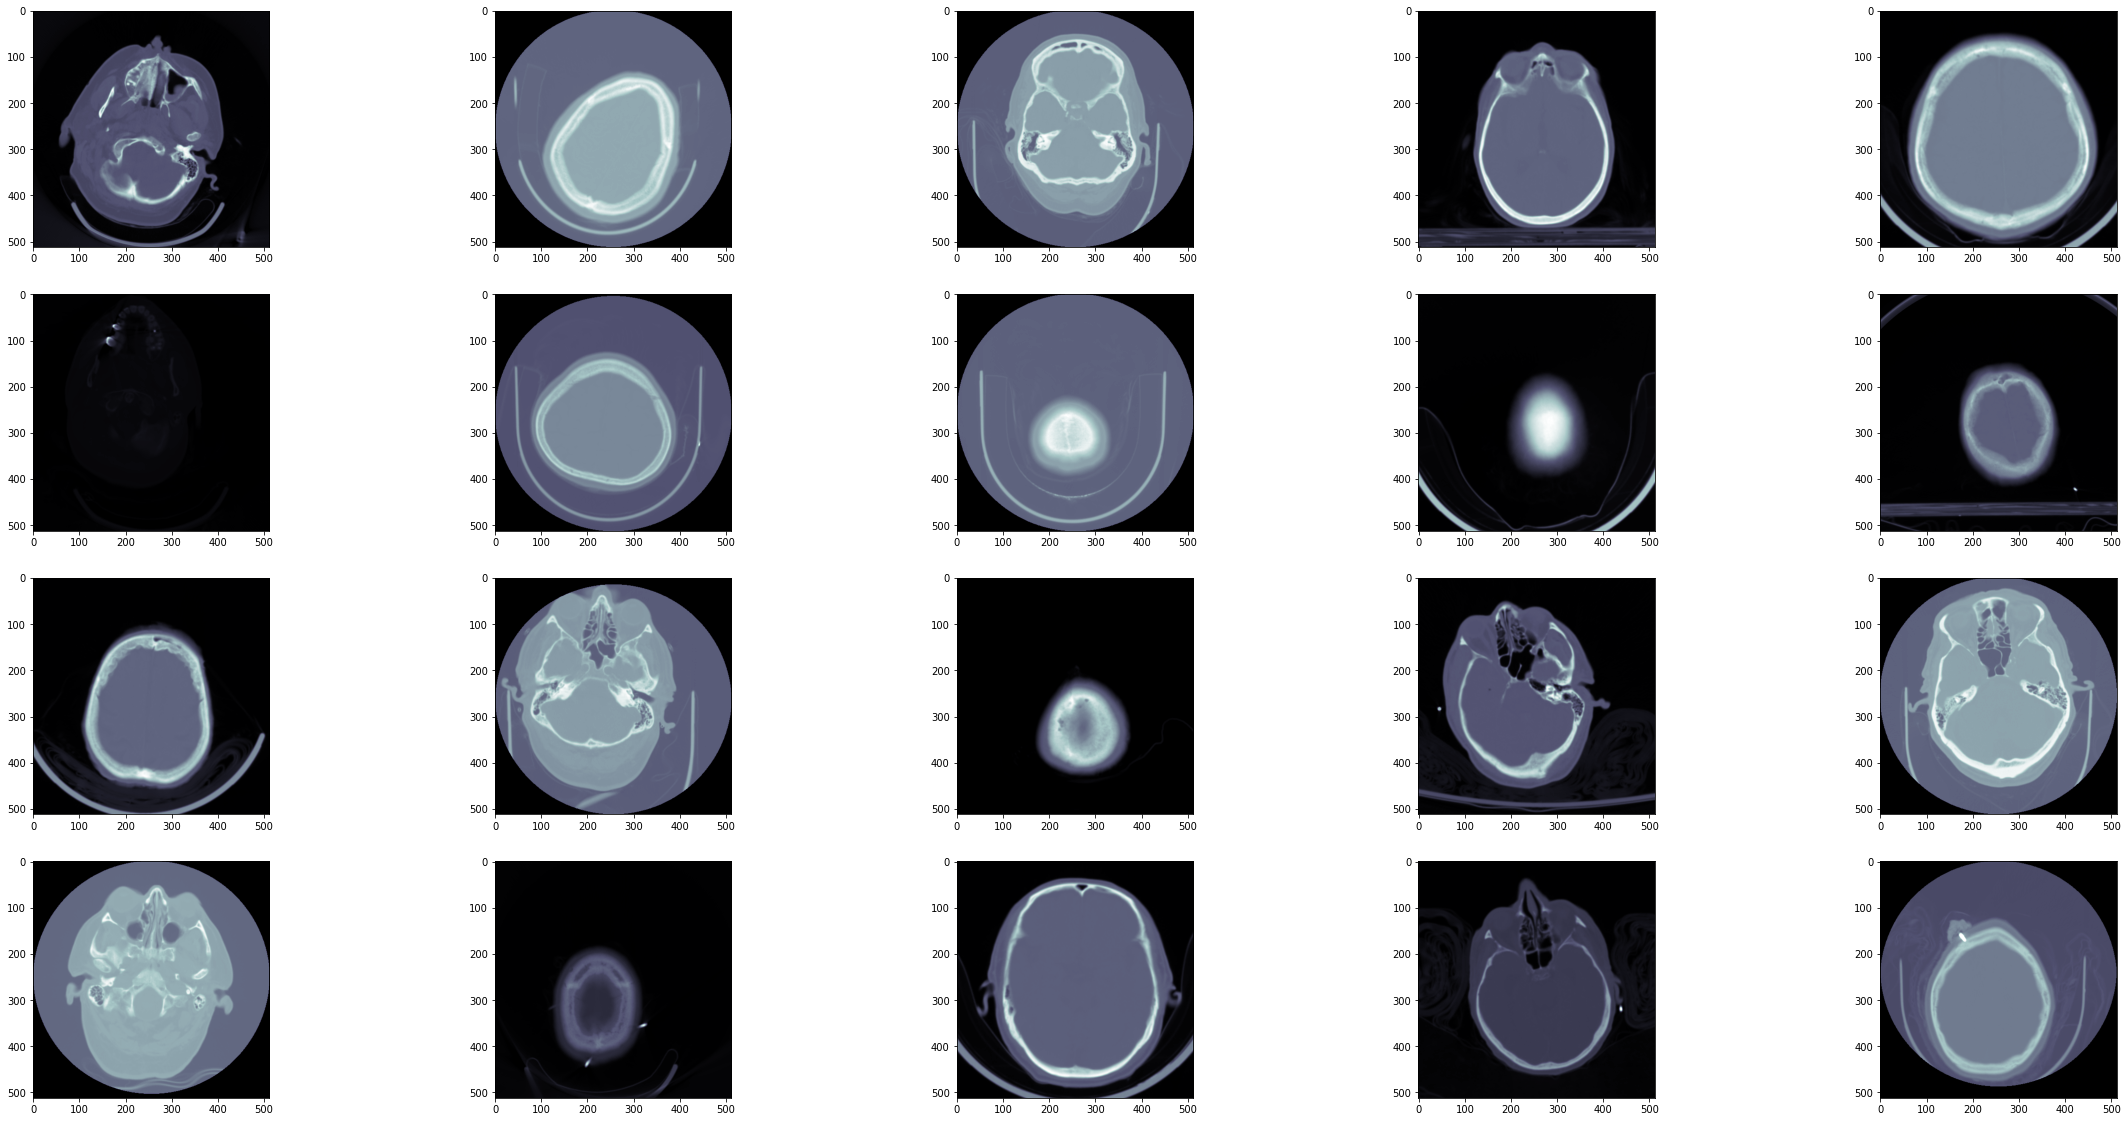

In [ ]:
fig = plt.figure(figsize=(40,20))
column= 5; rows = 4
for i in range(1, column*rows +1):
    dcm = pydicom.dcmread("stage_2_train/"+train_files[i])
    fig.add_subplot(rows, column, i)
    plt.imshow(dcm.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

In [ ]:
print(dcm)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 188
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.4267.32.315271899336265032565215546341568182903
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_bf44f0b2c
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_ae2ba27f'
(0020, 000d) Study Instance UID                  UI: ID_1e17f45929
(0020, 000e) Series Instance UID                 UI: ID_eae9fa73e6
(0020, 0010) Study ID                            SH: '

/usr/local/lib/python3.7/dist-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: 'ID_bf44f0b2c'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: 'ID_1e17f45929'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: 'ID_eae9fa73e6'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F
import os
from tqdm import tqdm

In [6]:
SIZE = 100
START = 0
#INPUT_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
train_images_dir = 'stage_2_train/'
test_images_dir = 'stage_2_test/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
def load_dataframe(csv_file):
    info = pd.read_csv(csv_file)
    info['Sub_type'] = info['ID'].str.split("_", n = 3, expand = True)[2]
    info['ID'] = info['ID'].str.split("_", n = 3, expand = True)[0]+'_'+info['ID'].str.split("_", n = 3, expand = True)[1]
    info = info.sort_values(by=['ID','Sub_type'], ignore_index=True)

    info['any'] = np.where(info['Sub_type'] == 'any', info['Label'], 0)
    info['epidural'] = np.where(info['Sub_type'] == 'epidural', info['Label'], 0)
    info['intraparenchymal'] = np.where(info['Sub_type'] == 'intraparenchymal', info['Label'], 0)
    info['intraventricular'] = np.where(info['Sub_type'] == 'intraventricular', info['Label'], 0)
    info['subarachnoid'] = np.where(info['Sub_type'] == 'subarachnoid', info['Label'], 0)
    info['subdural'] = np.where(info['Sub_type'] == 'subdural', info['Label'], 0)

    df = info.drop(columns=['Label', 'Sub_type']).groupby('ID').sum().reset_index()
    
    return df

In [8]:
df = load_dataframe("stage_2_train.csv")
test_df = load_dataframe('stage_2_sample_submission.csv')
print("Loaded!!!")

Loaded!!!


In [9]:
dfw = df.copy()
zeros = df.copy()
# dfw = dfw[['ID','any']]
zeros = zeros[zeros['any'] == 0]

print("any:", len(dfw[dfw['any']==1]))
print("epidural:", len(dfw[dfw['epidural']==1]))
print("intraparenchymal:", len(dfw[dfw['intraparenchymal']==1]))
print("intraventricular", len(dfw[dfw['intraventricular']==1]))
print("subarachnoid:", len(dfw[dfw['subarachnoid']==1]))
print("subdural:", len(dfw[dfw['subdural']==1]))

zeros_to_be_dropped = np.random.choice(zeros.index, 6*len(zeros)//7, replace=False)
# dfw = dfw.drop(index=zeros_to_be_dropped)
# # dfw = dfw.sample(frac=.1)
train, test = train_test_split(dfw, test_size=0.2, shuffle=True)

any: 107933
epidural: 3145
intraparenchymal: 36118
intraventricular 26205
subarachnoid: 35675
subdural: 47166


In [10]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [11]:
def final_windowing(img_path):

    window_sizes = [(40, 80), (75,215), (600,2800)]

    def preprocess(img_path, WINDOW_LEVEL, WINDOW_WIDTH):
        # params
        window_min = WINDOW_LEVEL-(WINDOW_WIDTH // 2)
        window_max = WINDOW_LEVEL+(WINDOW_WIDTH // 2)
        # read dicom file
        r = pydicom.read_file(img_path)
        # convert to hounsfield unit
        img = (r.pixel_array * r.RescaleSlope) + r.RescaleIntercept
        # apply brain window
        img = np.clip(img, window_min, window_max)
        img = 255 * ((img - window_min)/WINDOW_WIDTH)
        img = img.astype(np.uint8)
        return img

    new_arr = []
    try:
        for x in window_sizes:
            imag = preprocess(img_path, x[0], x[1] )
            new_arr.append(imag)
    except:
        new_arr = []
        for i in range(3):
            new_arr.append(np.zeros((512, 512)))

    new_arr_2 = np.dstack((new_arr[0], new_arr[1], new_arr[2]))

    return new_arr_2

In [12]:
class HemorrhageImageDataset(Dataset):
    """CT scan dataset."""

    def __init__(self, dataframe, root_dir, windowing=final_windowing, transform=transforms.ToTensor()):
        """
        Args:
            data_frame (pd.df): Panda Dataframe of the labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.(windowing function)
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.windowing = windowing
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.dataframe.iloc[idx, 0]
        image_arr = self.windowing(self.root_dir + img_name + '.dcm')
        image_arr.resize((224, 224, 3), refcheck=False)
        image = image_arr/256 # normalization
        
        labels = self.dataframe.iloc[idx, 1:]
        labels = np.array([labels])
        labels = labels.astype('float').reshape(6,)
        
        image = image.transpose((2, 0, 1))
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = torch.from_numpy(image)
        labels = torch.from_numpy(labels)
        
        return image, labels

In [13]:
trainset = HemorrhageImageDataset(
    train,
    train_images_dir
)
train_loader = DataLoader(
    trainset, 
    batch_size=10,
    shuffle=True, 
    num_workers=2
)


testset = HemorrhageImageDataset(
    test,
    train_images_dir
)
test_loader = DataLoader(
    testset, 
    batch_size=10,
    shuffle=True, 
    num_workers=2
)

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        resnext = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
#         inception = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
        self.base = torch.nn.Sequential(*list(resnext.children())[:-1])
        self.rnn = nn.LSTM(2048, 256, 1, bidirectional=True)
        self.fc = torch.nn.Linear(512+2048, 6)
        

    def forward(self, input):
        #----------------RESNET OUTPUTS----------------
        res_out = self.base(input).reshape(-1, 2048)
        #-----------------BLSTM OUTPUTS----------------
        h0 = torch.randn(2, 256).to(device)
        c0 = torch.randn(2, 256).to(device)
        rnn_out, (hn, cn) = self.rnn(res_out, (h0, c0))
        #----------------CONCATENATION-----------------
        concatenated = torch.cat((rnn_out, res_out), 1)
        #----------------FINAL FEATURES-----------------
        logits = self.fc(concatenated)
        #----------------------------------------------
        return logits


    
class ResNeXtModel(torch.nn.Module):
    def __init__(self):
        super(ResNeXtModel, self).__init__()
        resnext = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
        self.base = torch.nn.Sequential(*list(resnext.children())[:-1])
        self.fc = torch.nn.Linear(2048, 6)

    def forward(self, input):
        features = self.base(input).reshape(-1, 2048)
        logits = self.fc(features)
        return logits


    
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 3, 5)
        self.flatten_out_shape = 0
        self.fc1 = nn.Linear(8427, 1048)
        self.fc2 = nn.Linear(1048, 128)
        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ResNeXtModel().to(device=device)

Downloading: "https://github.com/facebookresearch/WSL-Images/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    train_loss, correct = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.float().to(device)
        y = y.float().to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        
        train_loss += loss.item()
        pred_bin = torch.where(pred < .5, 0., 1.)
        correct += int(torch.sum(torch.prod(pred_bin.eq(y), 1)))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            print(f"train_loss: {train_loss:>7f}   Accuracy: {correct / (batch+1)*32 * 100}")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.float().to(device)
            y = y.float().to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = torch.where(pred < .5, 0., 1.)
            correct += int(torch.sum(torch.prod(pred.eq(y), 1)))

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [16]:
torch.cuda.empty_cache()
learning_rate = 5e-4
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = custom_loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.704244  [    0/602242]
train_loss: 0.704244   Accuracy: 25600.0


KeyboardInterrupt: ignored

In [17]:
import torch
from torchvision.models.resnet import ResNet, Bottleneck
from torch.hub import load_state_dict_from_url

In [18]:
#Importing the model
model_urls = {
    'resnext101_32x8d': 'https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth',
    'resnext101_32x16d': 'https://download.pytorch.org/models/ig_resnext101_32x16-c6f796b0.pth',
    'resnext101_32x32d': 'https://download.pytorch.org/models/ig_resnext101_32x32-e4b90b00.pth',
    'resnext101_32x48d': 'https://download.pytorch.org/models/ig_resnext101_32x48-3e41cc8a.pth',
}

In [19]:
#Setting up the model
def _resnext(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
    model.load_state_dict(state_dict)
    return model

def resnext101_32x8d_wsl(progress=True, **kwargs):
    """Constructs a ResNeXt-101 32x8 model pre-trained on weakly-supervised data
    and finetuned on ImageNet from Figure 5 in
    `"Exploring the Limits of Weakly Supervised Pretraining" <https://arxiv.org/abs/1805.00932>`_
    Args:
        progress (bool): If True, displays a progress bar of the download to stderr.
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnext('resnext101_32x8d', Bottleneck, [3, 4, 23, 3], True, progress, **kwargs)

In [20]:
n_classes = 6
model = resnext101_32x8d_wsl()
model.fc = torch.nn.Linear(2048,n_classes)

In [21]:
%cd /content/drive/My Drive/DataSets/small_rsna_v1

/content/drive/My Drive/DataSets/small_rsna_v1


In [22]:
#Loading state dictionaries
model = torch.nn.DataParallel(model)
checkpoint = torch.load('model_e10_final.pt')
model.load_state_dict(checkpoint['model'])

RuntimeError: ignored

In [23]:
from albumentations.pytorch import ToTensor 

In [24]:
from albumentations import Compose, ShiftScaleRotate, Resize, Normalize, HorizontalFlip, RandomBrightnessContrast,CenterCrop
#from albumentations.pytorch.transforms import ToTensorV2
transform_test = Compose([CenterCrop(200,200),
                           ToTensor()])

In [25]:
import cv2
img1 = cv2.imread("ID_00032d440.png")
print(img1)
# augmented = transform_test(image=img1)
sample_img = transform_test(image=img1)['image'].unsqueeze(0)
print(sample_img.shape)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
torch.Size([1, 3, 200, 200])
